In [59]:
import glob 
import numpy as np
import os

In [60]:
t_l = 0.475 #  Espesor de la capa [mm]
t_n = 2.934
A_s = 0.283 # mm^2
A_s = 0.3098717890568393 # mm^2
r = 3*t_l/8 
d = (A_s - np.pi*r**2)/(2*r) # Area de la capa [mm^2]
params_composite ={
    "r"         :  r,
    "d"         :  d,
    "h"         :  t_l,
    "z0"        :  t_n/2,
    "density"   : 5,
}

E_Resina =  0.5996*1e3 
E_Carbon =  13.1473*1e3
params_ccx = {
    "epsilon" : 0.1,
    "x_fixed" : False,
    "E_nucleo": 0.8800*1e3,
    "E_resina": E_Resina,
    "E_fibra" : E_Carbon
}
params = {
    "mesh" : params_composite,
    "ccx"  : params_ccx,
}

In [61]:
frds = glob.glob("output/ccx/*/*.frd")

In [62]:
from djccx.frd.readfrd import readfrd


ifrd = readfrd(frds[0])

In [63]:
# deep copy
import copy

In [64]:
def setZline(Alines, t_l, t_n):
    ni = len(Alines.keys())
    zspan = (np.arange(ni)+0.5)*t_l + t_n/2
    keys = list(Alines.keys())

    Anew = []
    for iz, key in zip(zspan, keys):
        trajs = copy.deepcopy(Alines[key])
    
        for itrajs in trajs:
            itrajs[:,2] = iz # zspan[iz]
        
            Anew.append(itrajs)
    return Anew

In [65]:
from FEM_traccion.CreateLines.CreateLines import CreateLines

lines = CreateLines({
        "r": 2.5,
        "Nx_sq": 1,
        "Ny_sq": 1,
        "type":  'sin' # 'circle' or 'sin'
    })

In [66]:
lines["designs"].keys()


dict_keys(['A', 'B', 'C', 'D', 'E', 'F', 'Adouble'])

In [67]:
frds.sort()
frds

['output/ccx/Adouble/main.frd',
 'output/ccx/B/main.frd',
 'output/ccx/C/main.frd',
 'output/ccx/D/main.frd',
 'output/ccx/E/main.frd',
 'output/ccx/F/main.frd']

In [68]:
if os.name == "nt":
    list_design = [ ifrds.split(os.sep)[1] for ifrds in frds]
else:
    list_design = [ ifrds.split(os.sep)[-2] for ifrds in frds]
design = [ setZline(lines["designs"][key], t_l, t_n) for key in 
          list_design ]

In [69]:
list_design

['Adouble', 'B', 'C', 'D', 'E', 'F']

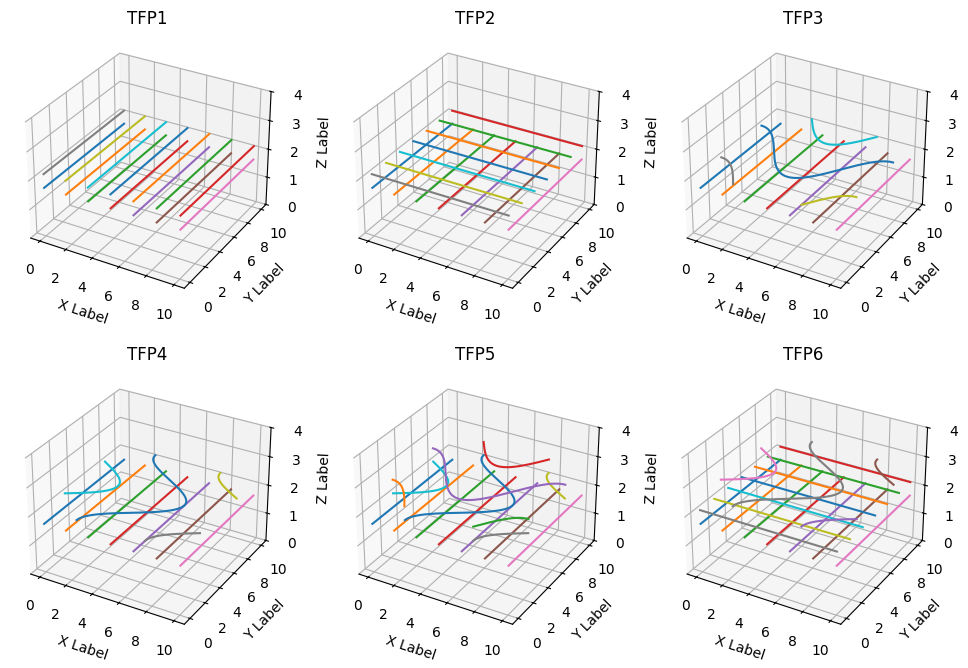

In [70]:
# 3d plot 
import matplotlib.pyplot as plt

fig = plt.figure()
fig.set_size_inches(12, 8)
for i in range(1,7):
    ax = fig.add_subplot(2,3,i, projection='3d')
    for iA in design[i-1]:
        ax.plot(iA[:,0], iA[:,1], iA[:,2])
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    # zlim
    ax.set_zlim(0, 4)
    title = "TFP" + str(i) 
    ax.set_title(title)

In [71]:
from scipy.interpolate import NearestNDInterpolator
from gmshtools.grid_section import grid_section


def compute_P1_max(data,idesign,params_composite):

    x = data["x"]
    y = data["y"]
    z = data["z"]
    P1 = data["P1"]

    fcn = NearestNDInterpolator((x,y,z),P1)

    d = params_composite["d"]
    r = params_composite["r"]

    P1_mu_list = []
    for jj,jtrajs in enumerate(idesign):

        jtraj_diff = np.diff(jtrajs,axis=0)

        for j in range(0,len(jtraj_diff),600):

            vec_z =  jtraj_diff[j]
            vec_z = vec_z/np.linalg.norm(vec_z)
            vec_x = np.cross(vec_z, [0,0,1])
            vec_x = vec_x/np.linalg.norm(vec_x)

            X,Y,Z = grid_section(jtrajs[j][0],
                                jtrajs[j][1],
                                jtrajs[j][2],
                                vec_z,
                                vec_x,
                                1.1*d,
                                1.1*r,
                                rho=150)
            P1 = fcn(X,Y,Z)
            P1_mu = np.mean(P1)
            P1_mu_list.append(P1_mu)

        # ============================

    P1_max = np.max(P1_mu_list)

    return P1_max

In [72]:
from djccx.inp.inp import inp

In [73]:
frds
inp_paths = [ i.replace(".frd",".inp") for i in frds]

In [74]:
inp_paths

['output/ccx/Adouble/main.inp',
 'output/ccx/B/main.inp',
 'output/ccx/C/main.inp',
 'output/ccx/D/main.inp',
 'output/ccx/E/main.inp',
 'output/ccx/F/main.inp']

In [75]:
ymin = 0.5 
ymax = 9.5
xmin = 0.5
xmax = 9.5

In [76]:
# neartest neighbor interpolation

P1_time_design = []
Sapl_list_design = []
P1_time_matrix_design = []
for ii in range(6):

    idesign = design[ii]
    ifrd = readfrd(frds[ii])
    inp_f = inp(inp_paths[ii])

    #
    BOX_PLUS = inp_f.select("BOX_PLUS","elset")
    df = BOX_PLUS.GetUniqueNodes(inp_f)
    indx_frd = df.index.values

    P1_time   = [0]
    Sapl_list = [0]
    P1_fibres_time = [0]
    # print("design",idesign)
    print("number of data blocks",len(ifrd["data_blocks"]))
    for kkk,data in enumerate(ifrd["data_blocks"]):
        print("kkk = ",kkk)
        # =============================
        # compute Sigma Aplicado
        # ============================
        zmin = data["z"].min()
        zmax = data["z"].max()
        ancho = zmax - zmin
        print("ancho",ancho)
        largo = 10 
        A = ancho*largo
        Sapl = np.sum(data["F2"]*(data["y"] > data["y"].mean()))/A
        Sapl_list.append(Sapl)

        # =============================
        # compute P1_max of fibres
        # ============================
        data_cp = data.copy()
        data_cp = data_cp[data_cp["x"] > xmin]
        data_cp = data_cp[data_cp["x"] < xmax]
        data_cp = data_cp[data_cp["y"] > ymin]
        data_cp = data_cp[data_cp["y"] < ymax]

        P1_max = compute_P1_max(data_cp,idesign,params_composite)
        
        P1_time.append(P1_max)

        # ============================
        # Compute P1_max of matrix
        # ============================
        data_cp = data.copy()

        nodes_matrix = data_cp.loc[indx_frd]

        data_cp = data_cp[data_cp["x"] > xmin]
        data_cp = data_cp[data_cp["x"] < xmax]
        data_cp = data_cp[data_cp["y"] > ymin]
        data_cp = data_cp[data_cp["y"] < ymax]
        
        id_max = np.argmax(data_cp["P1"])

        P1_max = data_cp["P1"].iloc[id_max]
        x_max = data_cp["x"].iloc[id_max]
        y_max = data_cp["y"].iloc[id_max]
        z_max = data_cp["z"].iloc[id_max]

        dist = np.sqrt((x_max - nodes_matrix["x"])**2 + \
                       (y_max - nodes_matrix["y"])**2 + \
                       (z_max - nodes_matrix["z"])**2)
        
        nodes_matrix = nodes_matrix[dist < 0.15]

        # print("number of nodes in matrix",len(nodes_matrix))
        # mean P1  
        # P1_max = np.mean(nodes_matrix["P1"])

        P1_fibres_time.append(P1_max)
        # ============================

    P1_time_matrix_design.append(P1_fibres_time)
    P1_time_design.append(P1_time)
    Sapl_list_design.append(Sapl_list)

number of data blocks 1
kkk =  0
ancho 2.417
number of data blocks 1
kkk =  0
ancho 2.417
number of data blocks 1
kkk =  0
ancho 2.417
number of data blocks 1
kkk =  0
ancho 2.417
number of data blocks 1
kkk =  0
ancho 2.892
number of data blocks 1
kkk =  0
ancho 2.892


In [77]:
# %matplotlib inline

In [78]:
nodes_matrix.head()

,node,x,y,z,D1,D2,D3,SXX,SYY,SZZ,...,EYZ,EZX,F1,F2,F3,STR(%),S_von_mises,P1,P2,P3
node,,,,,,,,,,,,,,,,,,,,,
11628,11628,6.92351,5.08602,2.65450,-0.098912,0.512765,-0.089361,14.7204,1023.260,47.82690,...,-0.003341,-0.018780,6.594090e-12,-2.995160e-11,5.395990e-12,9.33182,1033.338504,1049.582033,53.979707,-17.754440
11631,11631,6.93691,5.08881,2.58604,-0.097863,0.512125,-0.086780,25.1451,912.930,40.96080,...,0.002476,-0.025836,1.203680e-11,-3.486280e-11,-6.719900e-13,10.15960,913.753175,933.313046,67.667356,-21.944502
11632,11632,6.93691,5.08881,2.72296,-0.100564,0.512777,-0.091564,34.8645,1107.600,61.24920,...,-0.005884,-0.006717,-6.680350e-12,-3.910370e-12,-7.734370e-13,8.10399,1097.863670,1132.529343,61.627388,9.556970
11634,11634,6.98435,4.99489,2.52806,-0.098013,0.499412,-0.083988,-27.4014,669.862,-1.67779,...,-0.000592,-0.041945,3.961750e-12,1.214730e-11,4.958240e-12,10.39630,692.703648,669.950069,46.658945,-75.826204
11635,11635,6.93169,4.99437,2.65450,-0.099088,0.499235,-0.089049,-16.0178,1049.420,58.51090,...,0.000344,-0.019430,-4.409750e-13,-5.301370e-12,3.685320e-12,7.73771,1030.788438,1049.484946,62.782595,-20.354441


In [79]:
frds[ii]

'output/ccx/F/main.frd'

In [80]:
inp_paths[ii]

'output/ccx/F/main.inp'

In [81]:
ii = 2
idesign = design[ii]
ifrd = readfrd(frds[ii])
inp_f = inp(inp_paths[ii])
BOX_PLUS = inp_f.select("BOX_PLUS","elset")
df = BOX_PLUS.GetUniqueNodes(inp_f)
indx_frd = df.index.values

data =  ifrd["data_blocks"][-1]
data_cp = data.copy()

nodes_matrix = data_cp.loc[indx_frd]
# select indx_frd randomly 1000 nodes
idx_rand = np.random.choice(nodes_matrix.index, 3000, replace=False)
nodes_matrix = nodes_matrix.loc[idx_rand]


In [82]:
params_composite

{'r': 0.17812499999999998,
 'd': 0.5900174525193835,
 'h': 0.475,
 'z0': 1.467,
 'density': 5}

In [83]:
from scipy.interpolate import NearestNDInterpolator
from gmshtools.grid_section import grid_section


def compute_P1_max_plot(data,idesign,params_composite):

    x = data["x"]
    y = data["y"]
    z = data["z"]
    P1 = data["P1"]

    fcn = NearestNDInterpolator((x,y,z),P1)

    d = params_composite["d"]
    r = params_composite["r"]

    P1_mu_list = []

    sections = []

    for jj,jtrajs in enumerate(idesign):

        jtraj_diff = np.diff(jtrajs,axis=0)

        for j in range(0,len(jtraj_diff),300):

            vec_z =  jtraj_diff[j]
            vec_z = vec_z/np.linalg.norm(vec_z)
            vec_x = np.cross(vec_z, [0,0,1])
            vec_x = vec_x/np.linalg.norm(vec_x)


            X,Y,Z = grid_section(jtrajs[j][0],
                                jtrajs[j][1],
                                jtrajs[j][2],
                                vec_z,
                                vec_x,
                                1.1*d,
                                1.1*r,
                                rho=30)
            
            #sc
            # Z = Z + params_composite["h"]/2 + params_composite["z0"]

            P1 = fcn(X,Y,Z)
            sections.append({
                "X": X,
                "Y": Y,
                "Z": Z,
                "P1": P1
            })
            # scater plot
            P1_mu = np.mean(P1)
            P1_mu_list.append(P1_mu)
        # ============================

    P1_max = np.max(P1_mu_list)

    return P1_max,sections

In [84]:
# %matplotlib ipympl

In [85]:
P1_max,sections = compute_P1_max_plot(data_cp,idesign,params_composite)

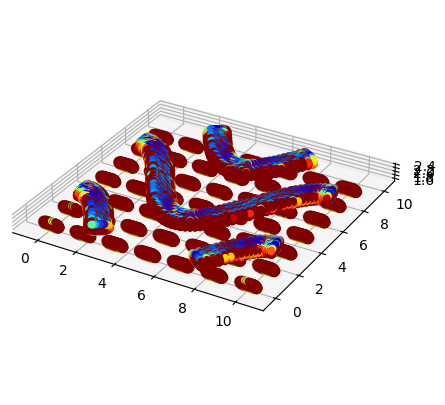

In [86]:
#sections plot 

fig = plt.figure(figsize=(5,5))

ax = fig.add_subplot(111,projection='3d')

ax.set_box_aspect([1,1,1])
for isection in sections:

    X = isection["X"]
    Y = isection["Y"]
    Z = isection["Z"]
    P1 = isection["P1"]
    ax.scatter(X,Y,Z,c=P1,vmax=100,vmin=0,cmap="jet")
    #ax.scatter(X,Y,Z,c=P1,marker="o",s=0.5)

# aspect 
ax.set_box_aspect([1,1,0.075])

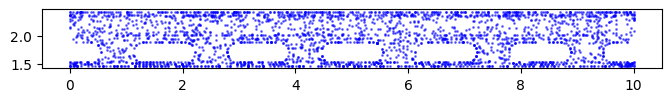

In [87]:
fig = plt.figure()

fig.set_size_inches(8, 8)
# 
plt.plot(nodes_matrix["x"], 
        nodes_matrix["z"],
        "o", markersize=1, alpha=0.5, color="blue")

# aspect ratio 1:1:1

plt.gca().set_aspect('equal', adjustable='box')
# elevation 0, azimuth -90deg, roll 0
ax.view_init(elev=0, azim=-90)

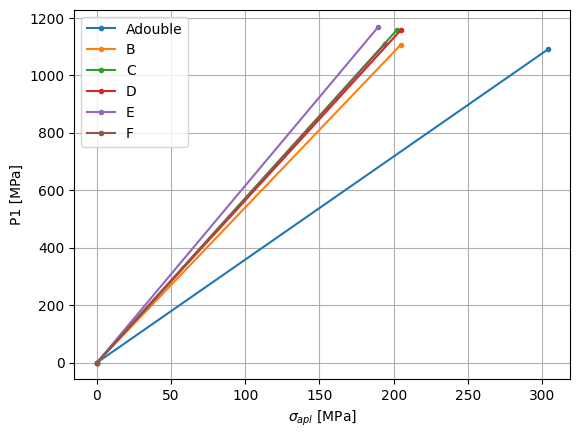

In [88]:
fig = plt.figure()
labels = list_design
for ii in range(6):
    iS_plot = Sapl_list_design[ii]
    iP_plot = P1_time_design[ii]

    plt.plot(iS_plot,iP_plot,'.-', label=labels[ii])
plt.xlabel(r"$\sigma_{apl}$ [MPa]")
plt.ylabel("P1 [MPa]")
plt.legend()
plt.grid()  

In [89]:
ratio_fibra = [ P1_time_design[ii][-1]/Sapl_list_design[ii][-1] for ii in range(6)]
ratio_matrix = [ P1_time_matrix_design[ii][-1]/Sapl_list_design[ii][-1] for ii in range(6)]
# ratio = {
#     "TPF1": {"fibra": ratio_fibra[0], "matrix": ratio_matrix[0]},
#     "TPF2": {"fibra": ratio_fibra[1], "matrix": ratio_matrix[1]},
#     "TPF3": {"fibra": ratio_fibra[2], "matrix": ratio_matrix[2]},
#     "TPF4": {"fibra": ratio_fibra[3], "matrix": ratio_matrix[3]}, 
#     ...
# }

ratio = { "TPF" + str(i+1): {"fibra": ratio_fibra[i], "matrix": ratio_matrix[i]} for i in range(6) }

In [90]:
ratio

{'TPF1': {'fibra': np.float64(3.587457471866745),
  'matrix': np.float64(4.327872807501836)},
 'TPF2': {'fibra': np.float64(5.403518860037398),
  'matrix': np.float64(6.888494459094253)},
 'TPF3': {'fibra': np.float64(5.7278893568103175),
  'matrix': np.float64(7.286532737320292)},
 'TPF4': {'fibra': np.float64(5.652140844098677),
  'matrix': np.float64(8.157721107000215)},
 'TPF5': {'fibra': np.float64(6.163641252309474),
  'matrix': np.float64(8.727194297395801)},
 'TPF6': {'fibra': np.float64(5.714768316212657),
  'matrix': np.float64(8.552842415769355)}}

In [91]:
analitico_path = r"C:\Users\djoroya\Documents\GitHub\CITISENS_Composite_v2\scripts_finals\01_metodo\01_traccion\04_optim_stress\df_pred.csv"
analitico_path = "../../01_metodo/01_traccion/04_optim_stress/df_pred.csv"
import pandas as pd 

df_pred_analitico = pd.read_csv(analitico_path)

In [92]:
df_pred_analitico

,Name,Et [GPa],Eb [GPa],St [MPa],Sb [MPa]
0,TFP1,3.039654,5.146051,207.772728,351.753532
1,TFP2,2.031433,2.676869,138.856707,227.729294
2,TFP3,2.002071,2.604960,136.849690,221.611769
3,TFP4,2.027407,2.667010,125.073250,164.531138
4,TFP5,1.874255,2.030099,115.625120,125.239324
5,TFP6,1.898795,2.072077,117.138990,127.828982


In [93]:
analitico_path_opt = r"C:\Users\djoroya\Documents\GitHub\CITISENS_Composite_v2\scripts_finals\01_metodo\01_traccion\04_optim_stress\df_opt.csv"
analitico_path_opt = "../../01_metodo/01_traccion/04_optim_stress/df_opt.csv"

df_opt_analitico = pd.read_csv(analitico_path_opt)
df_opt_analitico

,Variable,x,unit
0,S_fibra,1609.175713,MPa
1,S_matrix,893.853962,MPa


In [94]:
df_opt_analitico.iloc[1]["x"]

np.float64(893.8539621783527)

In [95]:
from validation.FullExperimental import FullExperimental

fe = FullExperimental()
St_experimental = fe["St [MPa]"]["mean"].values
St_experimental

array([279.10333333, 153.36      , 137.11333333, 184.39666667,
        99.99      , 104.51333333])

In [96]:
ratio

{'TPF1': {'fibra': np.float64(3.587457471866745),
  'matrix': np.float64(4.327872807501836)},
 'TPF2': {'fibra': np.float64(5.403518860037398),
  'matrix': np.float64(6.888494459094253)},
 'TPF3': {'fibra': np.float64(5.7278893568103175),
  'matrix': np.float64(7.286532737320292)},
 'TPF4': {'fibra': np.float64(5.652140844098677),
  'matrix': np.float64(8.157721107000215)},
 'TPF5': {'fibra': np.float64(6.163641252309474),
  'matrix': np.float64(8.727194297395801)},
 'TPF6': {'fibra': np.float64(5.714768316212657),
  'matrix': np.float64(8.552842415769355)}}

In [97]:

labels = ["TPF" + str(i+1) for i in range(6)]

Sfibre_0  = df_opt_analitico.iloc[0]["x"]
Smatrix_0 = df_opt_analitico.iloc[1]["x"]

def PredFEM(Sfibre, Smatrix):
    
    Srotura = []
    for ii in range(6):

        Sposibles  = [Sfibre/ratio[labels[ii]]["fibra"],Smatrix/ratio[labels[ii]]["matrix"]]
        idx_S = np.argmin(Sposibles)
        S = Sposibles[idx_S]

        Srotura.append(S)

    return np.array(Srotura)

PredFEM(Sfibre_0, Smatrix_0)

def Loss(x):
    Sfibre = x[0]
    Smatrix = x[1]

    Srotura = PredFEM(Sfibre, Smatrix)

    # compute the loss
    loss = np.sum((Srotura - St_experimental)**2)

    return loss

from scipy.optimize import minimize
x0 = [Sfibre_0, Smatrix_0]
res = minimize(Loss, x0, method='Nelder-Mead', options={'disp': True, 'maxiter': 1000})
Sfibre_opt, Smatrix_opt = res.x

Optimization terminated successfully.
         Current function value: 4492.442227
         Iterations: 62
         Function evaluations: 132


In [98]:
Sfibre = Sfibre_opt
Smatrix = Smatrix_opt

In [99]:
print("Sfibre_opt:", Sfibre)
print("Smatrix_opt:", Smatrix)

Sfibre_opt: 1168.115459611388
Smatrix_opt: 1123.7888939523025


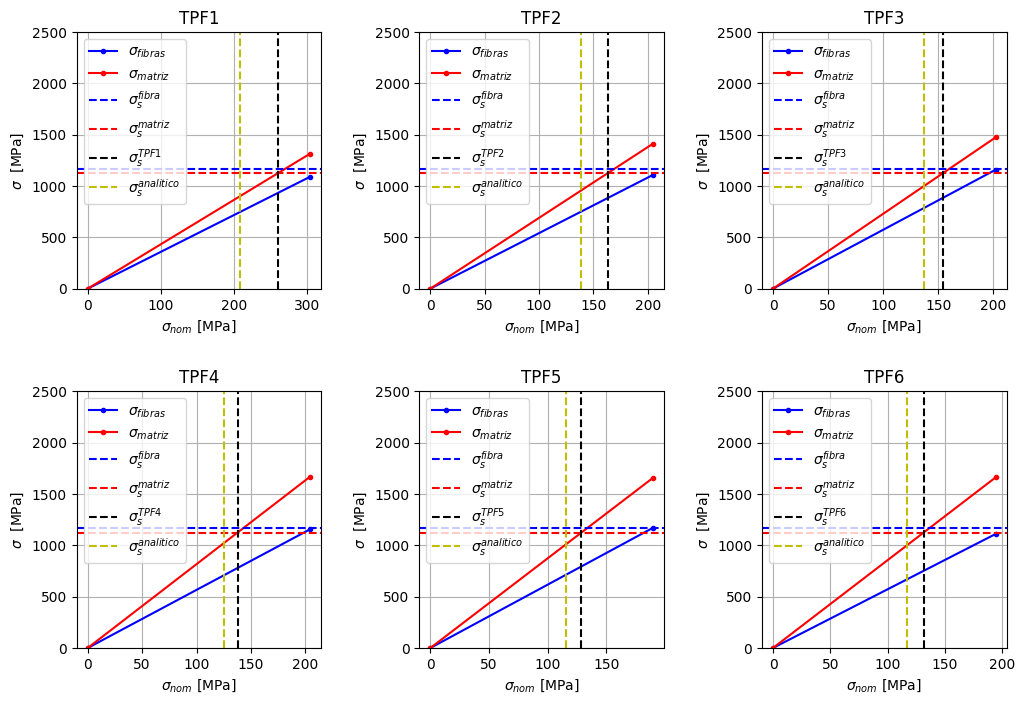

In [100]:
labels = ["TPF" + str(i+1) for i in range(6)]
fig = plt.figure(figsize=(12, 8))
#subplot 
plt.subplots_adjust(wspace=0.4, 
                    hspace=0.4)

# Sfibre = df_opt_analitico.iloc[0]["x"]
# Smatrix = df_opt_analitico.iloc[1]["x"]

S_TFP_analitico = df_pred_analitico["St [MPa]"].values

colors = ["b","r"]

Srotura = []
for ii in range(6):

    # subplot 
    plt.subplot(2,3,ii+1)
    plt.plot(Sapl_list_design[ii],P1_time_design[ii],'.-', label=r"$\sigma_{fibras}$",color='b')
    plt.plot(Sapl_list_design[ii],P1_time_matrix_design[ii],'.-', label= r"$\sigma_{matriz}$",color='r')
    
    plt.axhline(y=Sfibre, linestyle='--', label=r"$\sigma_s^{fibra}$",color='b')
    plt.axhline(y=Smatrix, linestyle='--', label=r"$\sigma_s^{matriz}$",color='r')

    Sposibles  = [Sfibre/ratio[labels[ii]]["fibra"],Smatrix/ratio[labels[ii]]["matrix"]]
    idx_S = np.argmin(Sposibles)
    S = Sposibles[idx_S]

    Srotura.append(S)

    label = r"$\sigma_s^{CC}$"  
    label = label.replace("CC",labels[ii])
    plt.axvline(x=S, linestyle='--', 
                label=label,
                color="k")
    
    plt.axvline(x=S_TFP_analitico[ii], linestyle='--',
                label=r"$\sigma_s^{analitico}$",
                color="y")

    # [0,0] -> [ S,]
    plt.xlabel(r"$\sigma_{nom}$ [MPa]")
    plt.ylabel(r"$\sigma$  [MPa]")
    plt.title(labels[ii])
    plt.legend()
    plt.grid()  
    plt.ylim(0,2500)


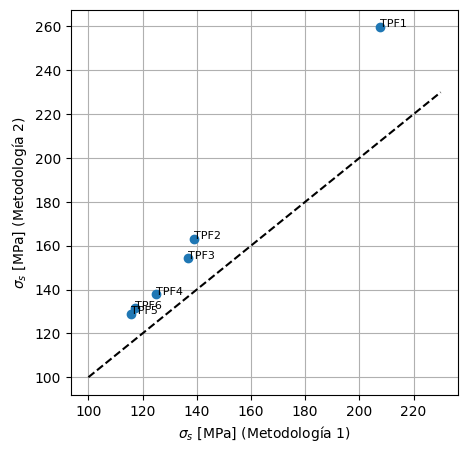

In [101]:
plt.figure(figsize=(5, 5))

plt.plot( 1.0*S_TFP_analitico,Srotura, 'o')
# 1:1 line
plt.plot([100, 230], [100, 230], 'k--')
plt.xlabel(r"$\sigma_s$ [MPa] (Metodología 1)")
plt.ylabel(r"$\sigma_s$ [MPa] (Metodología 2)")
plt.grid()
#text 
for i, txt in enumerate(labels):
    plt.annotate(txt, (S_TFP_analitico[i],Srotura[i]), fontsize=8)

In [102]:
# %matplotlib inline

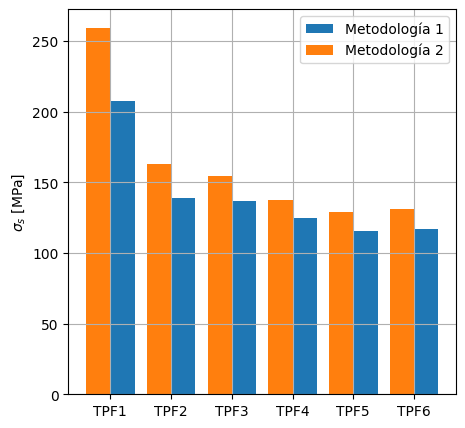

In [103]:
# bar 
plt.figure(figsize=(5, 5))

xspace = np.arange(len(labels))
plt.bar(xspace + 0.2, S_TFP_analitico, width=0.4, label=r"Metodología 1")

plt.bar(xspace - 0.2, Srotura, width=0.4, label=r"Metodología 2")
plt.xticks(xspace, labels)
plt.ylabel(r"$\sigma_s$ [MPa]")
plt.grid()
plt.legend()

In [104]:
error_metod1 = np.abs(S_TFP_analitico - Srotura)
error_metod1_rel = error_metod1/Srotura*100

df_results = pd.DataFrame({
    "labels": labels,
    "S_TFP_analitico": S_TFP_analitico,
    "Srotura": Srotura,
    "error_metod1": error_metod1,
    "error_metod1_rel": error_metod1_rel
})
df_results = df_results.set_index("labels")
df_results.round(2)

,S_TFP_analitico,Srotura,error_metod1,error_metod1_rel
labels,,,,
TPF1,207.77,259.66,51.89,19.98
TPF2,138.86,163.14,24.28,14.88
TPF3,136.85,154.23,17.38,11.27
TPF4,125.07,137.76,12.68,9.21
TPF5,115.63,128.77,13.14,10.21
TPF6,117.14,131.39,14.25,10.85


In [105]:
Sapl_list_design

[[0, np.float64(303.93222261334154)],
 [0, np.float64(204.8431559055603)],
 [0, np.float64(202.07657948571713)],
 [0, np.float64(204.65517473339384)],
 [0, np.float64(189.77112851091675)],
 [0, np.float64(194.152623694025)]]

In [106]:
P1_time_matrix_design

[[0, np.float64(1315.3800015718755)],
 [0, np.float64(1411.0609444388324)],
 [0, np.float64(1472.437611868384)],
 [0, np.float64(1669.519838579424)],
 [0, np.float64(1656.1695105508384)],
 [0, np.float64(1660.5567950631635)]]

In [107]:
from validation.FullExperimental import FullExperimental
df = FullExperimental()
df.rename(columns={"v [X,SX,Y,SY]": "delta"}, inplace=True)

# database
layers = df["layers"].values
layers[0] = ["Y","Y"]
df["layers"] = layers

# df = df.iloc[1:]

df.round(3)

St_experimental = df["St [MPa]"]["mean"].values

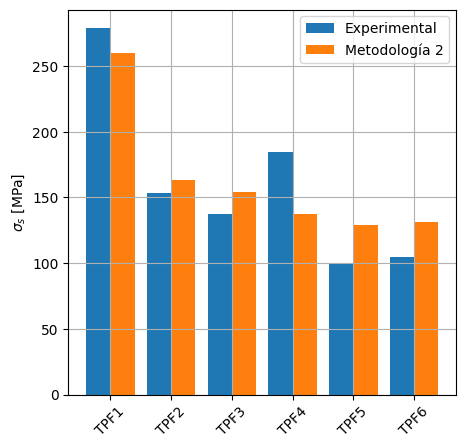

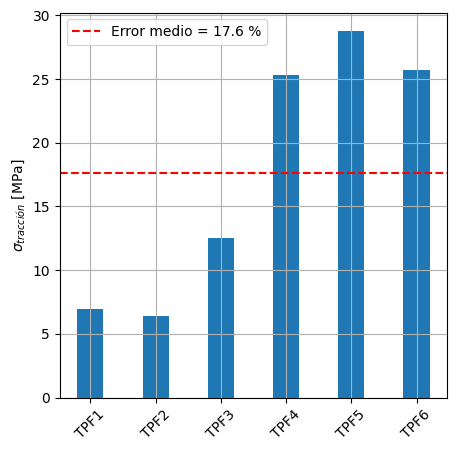

In [108]:
# compare with Srotura
fig = plt.figure(figsize=(5, 5))
plt.bar(xspace - 0.2, St_experimental, width=0.4, label=r"Experimental")
plt.bar(xspace + 0.2, Srotura, width=0.4, label=r"Metodología 2")
plt.grid()
plt.xticks(xspace, labels, rotation=45)
plt.ylabel(r"$\sigma_s$ [MPa]")
plt.legend()

fig = plt.figure(figsize=(5, 5))
error_abs = abs(St_experimental - Srotura)
error_rel = abs(St_experimental - Srotura)/St_experimental*100
plt.bar(xspace, error_rel, width=0.4)
plt.xticks(xspace, labels, rotation=45);
plt.ylabel(r"$\sigma_{tracción}$ [MPa]")
plt.grid()
error_mean = np.mean(error_rel)
plt.axhline(y=error_mean, linestyle='--', color='r', label="Error medio = " + str(round(error_mean,2)) + " %")
plt.legend()

In [109]:
df_results = pd.DataFrame({
    "labels": labels,
    "Srotura": Srotura,
    "St_experimental": St_experimental,
    "error_abs": error_abs,
    "error_rel": error_rel
})

In [110]:
df_results.round(3)

,labels,Srotura,St_experimental,error_abs,error_rel
0,TPF1,259.663,279.103,19.440,6.965
1,TPF2,163.140,153.360,9.780,6.377
2,TPF3,154.228,137.113,17.115,12.482
3,TPF4,137.758,184.397,46.639,25.293
4,TPF5,128.769,99.990,28.779,28.782
5,TPF6,131.394,104.513,26.880,25.719


In [111]:
# save 
df_results.to_csv("df_results.csv", index=False)